# VolcSARvatory

*Author: ASF-SciDev team*

**This notebook includes the minimum code to run an SBAS timeseries for a given AOI using multibursts. It has six main steps:**

* Adds a new AOI to the geoparquet file.
* Finds the burst ids that overlap with the AOI and validates the multiburst sets.
* Estimates the coherence for each season.
* Create the network for a given multiburst set.
* Prepares and submit the jobs into HyP3.
* Downloads the products and rename the files to make it compatible with MintPy.

## Import libraries

In [1]:
import asf_search as asf
import geopandas as gpd
import matplotlib.pyplot as plt
import pygmt

from datetime import datetime
from volcsarvatory import aoi, pairs
from volcsarvatory import prepare_multibursts as pm

# 1. Add area of interest (AOI)

**Here we show how to add a new area of interest in the parquet file. For islands, the function will discard area that is not in land. If the name already exists the parquet file the geometry will be replaced**

In this case we are adding a new area for Kilauea

In [2]:
extent = [-156.2, -154.7, 18.8, 20.4]

aoigdf = aoi.add_aoi('Kilauea', extent=extent)

/home/mfangaritasr/VolcSARvatory_new/VolcSARvatory/volcsarvatory/aoi.py:46: UserWarning: An AOI with the same ID exists in the dataframe. Replacing...
  warnings.warn('An AOI with the same ID exists in the dataframe. Replacing...', UserWarning)


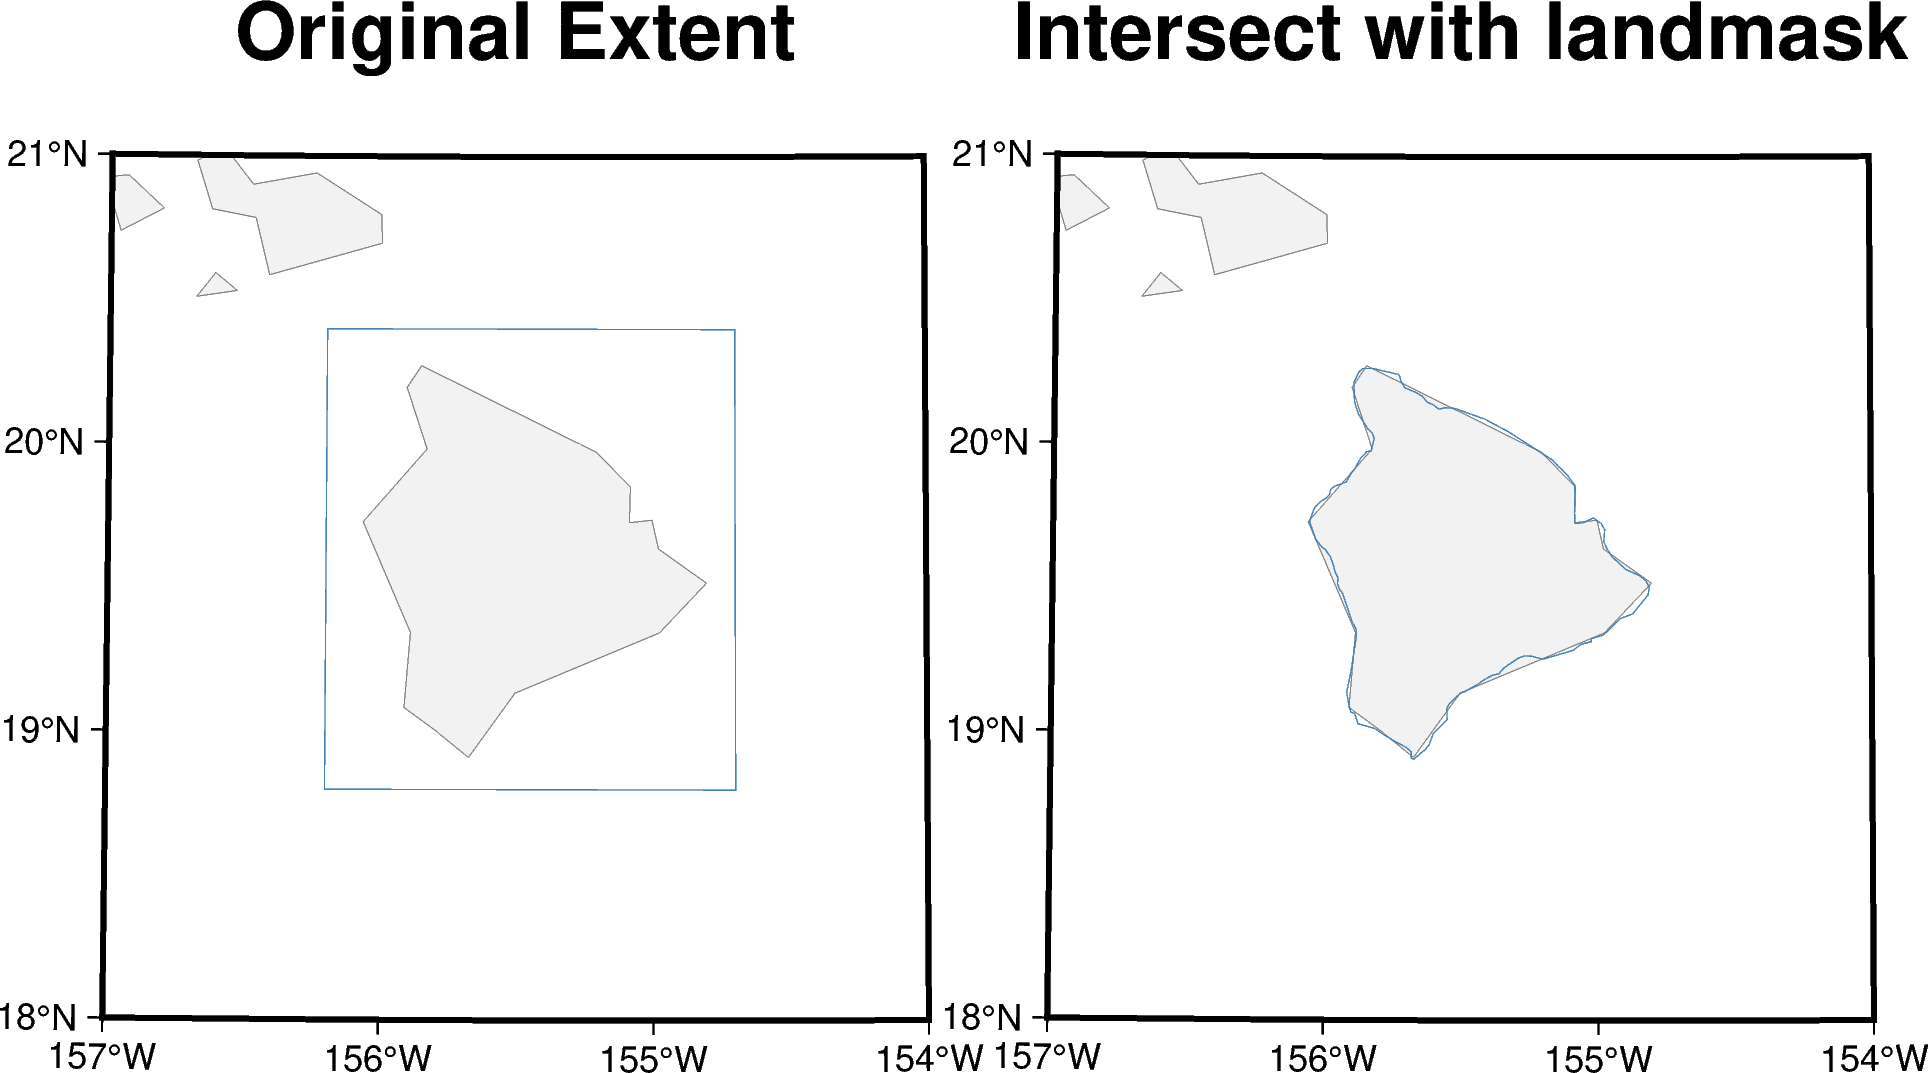

In [3]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE='plain')
fig.coast(
    region=[-157, -154, 18, 21],
    projection="L-155/18/20/21/7c",
    resolution="l",
    land="gray95",
    shorelines="1/0.1p,gray50",
    borders="1/0.1,gray30",
    frame=['a1','+tOriginal Extent'],
)

# Add rivers to map
x = [extent[0], extent[1], extent[1], extent[0], extent[0]]
y = [extent[2], extent[2], extent[3], extent[3], extent[2]]
fig.plot(x=x, y=y, pen="0.2p,steelblue")

fig.shift_origin(xshift="w+1c")
fig.coast(
    region=[-157, -154, 18, 21],
    projection="L-155/18/20/21/7c",
    resolution="l",
    land="gray95",
    shorelines="1/0.1p,gray50",
    borders="1/0.1,gray30",
    frame=['a1','+tIntersect with landmask'],
)

# Add rivers to map
fig.plot(data=aoigdf, pen="0.2p,steelblue")

fig.show()

# 2. Find burst ids that intersect an AOI

**This function get the burst ids that intersect with the AOI**

In [4]:
burst_dict = aoi.get_burst_ids(aoi_id = 'Kilauea')

/home/mfangaritasr/VolcSARvatory_new/VolcSARvatory/volcsarvatory/aoi.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bursts_gdf["area"] = gpd.overlay(s1_gdf, aoi_gdf, how='intersection').area.to_numpy()/bursts_gdf.area.to_numpy()


**The result is a dictionary where the keys are the burst ids and the elements are the AOI that they intersect**

In [5]:
print(burst_dict)

{'087_185678_IW2': array(['Kilauea'], dtype=object), '087_185679_IW2': array(['Kilauea'], dtype=object), '087_185680_IW1': array(['Kilauea'], dtype=object), '087_185680_IW2': array(['Kilauea'], dtype=object), '087_185681_IW1': array(['Kilauea'], dtype=object), '087_185681_IW2': array(['Kilauea'], dtype=object), '087_185682_IW1': array(['Kilauea'], dtype=object), '087_185682_IW2': array(['Kilauea'], dtype=object), '087_185683_IW1': array(['Kilauea'], dtype=object), '087_185683_IW2': array(['Kilauea'], dtype=object), '087_185684_IW1': array(['Kilauea'], dtype=object), '087_185684_IW2': array(['Kilauea'], dtype=object), '087_185685_IW2': array(['Kilauea'], dtype=object), '124_264303_IW2': array(['Kilauea'], dtype=object), '124_264304_IW2': array(['Kilauea'], dtype=object), '124_264304_IW3': array(['Kilauea'], dtype=object), '124_264305_IW2': array(['Kilauea'], dtype=object), '124_264305_IW3': array(['Kilauea'], dtype=object), '124_264306_IW2': array(['Kilauea'], dtype=object), '124_264306

**Validation**

Then the bursts have to merged into multiburst set that can be submitted to HyP3. This workflow checks, create and eventually fixes the multiburst sets. It considers the following:

* The multiburst jobs in HyP3 only accepts 15 bursts per job.
* HyP3 uses burst2safe to merge the bursts into a safe file. The tool does not accept holes in the set nor different ranges in the swaths.
* This workflow fills holes and complete the swaths so the multiburst is valid for HyP3

In [6]:
burst_ids = [bid for bid in burst_dict.keys()]
multibursts = pm.get_multibursts(burst_ids)

In [7]:
for multiburst in multibursts:
    print(multiburst.multiburst_dict)

{'124_264303': ('IW2',), '124_264304': ('IW2', 'IW3'), '124_264305': ('IW2', 'IW3'), '124_264306': ('IW2', 'IW3'), '124_264307': ('IW2', 'IW3'), '124_264308': ('IW2', 'IW3'), '124_264309': ('IW2', 'IW3'), '124_264310': ('IW2', 'IW3'), '124_264311': ('IW2',)}
{'087_185678': ('IW2',), '087_185679': ('IW1', 'IW2'), '087_185680': ('IW1', 'IW2'), '087_185681': ('IW1', 'IW2'), '087_185682': ('IW1', 'IW2'), '087_185683': ('IW1', 'IW2'), '087_185684': ('IW1', 'IW2'), '087_185685': ('IW2',)}


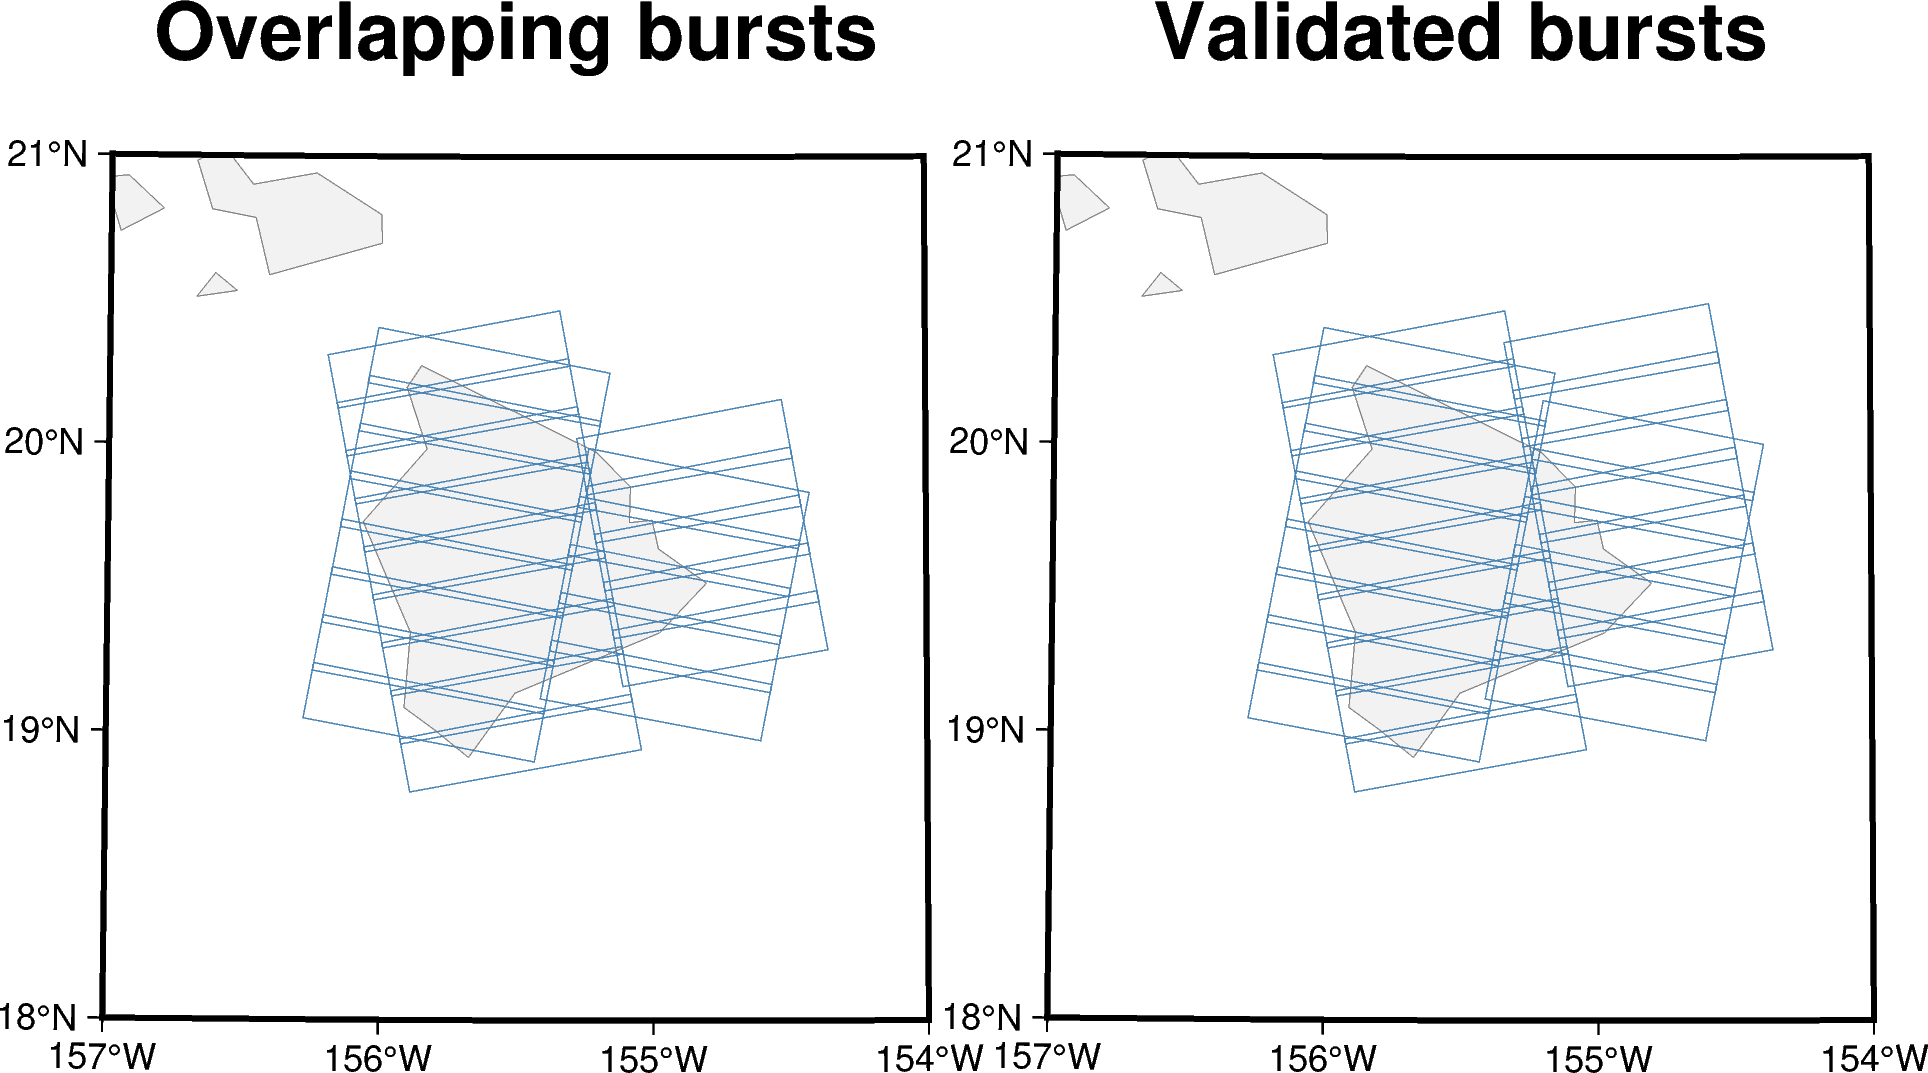

In [8]:
gdf = aoi.s1_gdf
gdf = gdf.to_crs("EPSG:4326")
s1gdf = gdf[gdf['id'].isin(burst_ids)]

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE='plain')
fig.coast(
    region=[-157, -154, 18, 21],
    projection="L-155/18/20/21/7c",
    resolution="l",
    land="gray95",
    shorelines="1/0.1p,gray50",
    borders="1/0.1,gray30",
    frame=['a1','+tOverlapping bursts'],
)

# Add rivers to map
fig.plot(data=s1gdf, pen="0.2p,steelblue")

new_burst_ids = []
for multiburst in multibursts:
    for bid in multiburst.multiburst_dict.keys():
        for swath in multiburst.multiburst_dict[bid]:
            new_burst_ids.append(bid+'_'+swath)

s1gdf = gdf[gdf['id'].isin(new_burst_ids)]

fig.shift_origin(xshift="w+1c")

fig.coast(
    region=[-157, -154, 18, 21],
    projection="L-155/18/20/21/7c",
    resolution="l",
    land="gray95",
    shorelines="1/0.1p,gray50",
    borders="1/0.1,gray30",
    frame=['a1','+tValidated bursts'],
)

# Add rivers to map
fig.plot(data=s1gdf, pen="0.2p,steelblue")

fig.show()

# 3. Estimate the coherence for a given multiburst set (currently not working without AWS credentials)

In this case we are using the multiburst set for path 87

In [9]:
path = '124'
stop=False
for multiburst in multibursts:
    for key in multiburst.multiburst_dict.keys():
        if path in key:
            stop=True
            break
    if stop:
        break

**Here the workflow estimates the mean coherence for a given number of bursts in the set**

In [10]:
coherence = pairs.get_coherence(multiburst.multiburst_dict, num = 1)

**The result is a dictionary where the keys represent the number of days between the pairs and the elements are dictionaries where the keys are the dates of the reference dates and the elements are the estimated coherence**

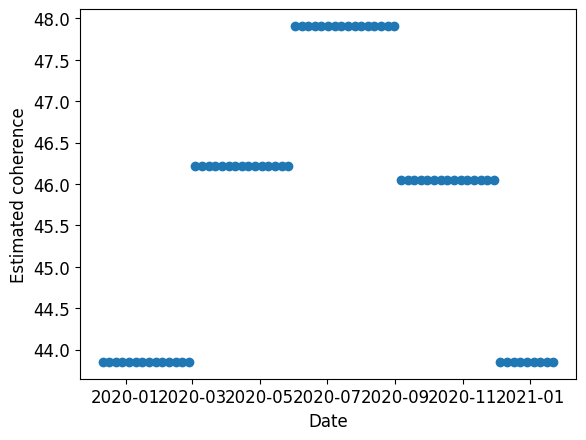

In [15]:
#Possible keys are 6, 12, 24 or 48. In this case we are plotting the coherence for 6 days pairs.
days = 6
cohs = [coherence[days][ref] for ref in coherence[days].keys()]
dates = [datetime.strptime(ref, '%Y-%m-%d') for ref in coherence[days].keys()]

plt.figure()
plt.scatter(dates, cohs)
plt.xlabel('Date')
plt.ylabel('Estimated coherence')
plt.show()

# 4. Build the network for the multiburst set
**Using the estimated coherence we can choose the optimal season and bridge date to build the network**

In [10]:
season = ("4-1", "11-1")

opts = asf.ASFSearchOptions(
    **{
        "start": '2015-01-01', 
        # "end": '2016-05-02', 
        # "start": '2022-01-01',
        "end": '2025-11-02',
        "season": pm.get_julian_season(season)
      }
)

network = asf.Network(
    multiburst = multiburst,
    perp_baseline=800, 
    inseason_temporal_baseline=24,
    bridge_target_date='8-1',
    bridge_year_threshold=1,
    opts=opts)

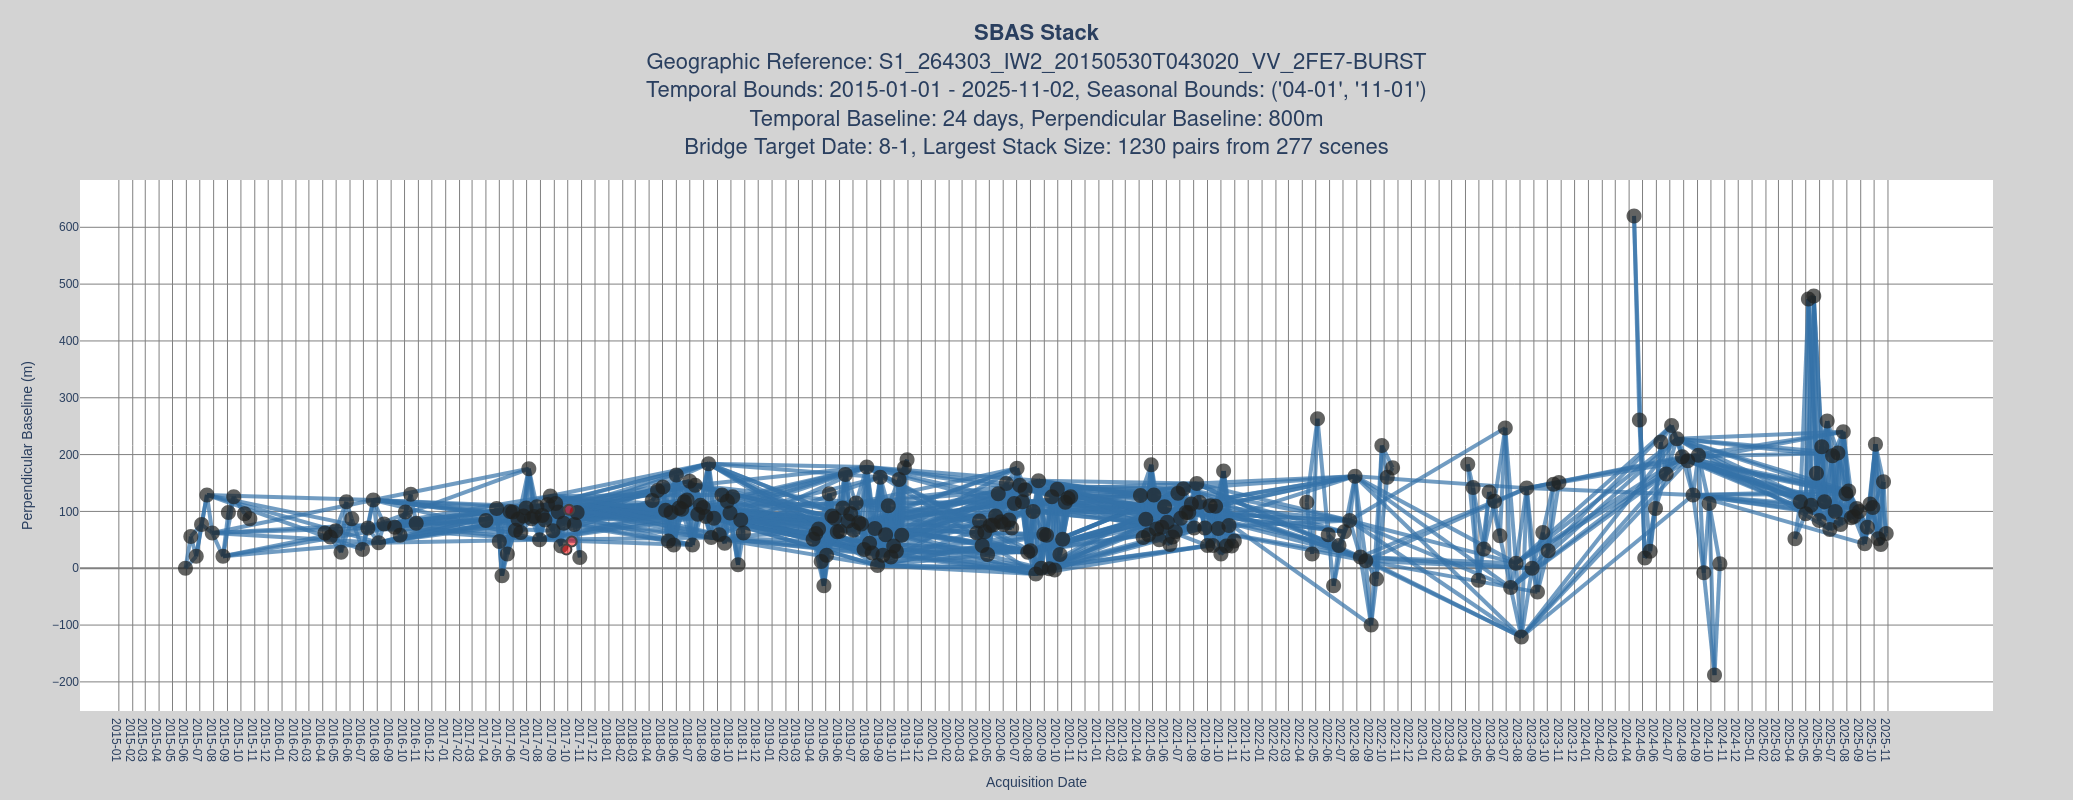

In [11]:
network.plot()

<div class="alert alert-block alert-warning">
<b>Warning:</b> The next cell should be run only if there are multiple components in the network
</div>

In [14]:
network.connect_components()

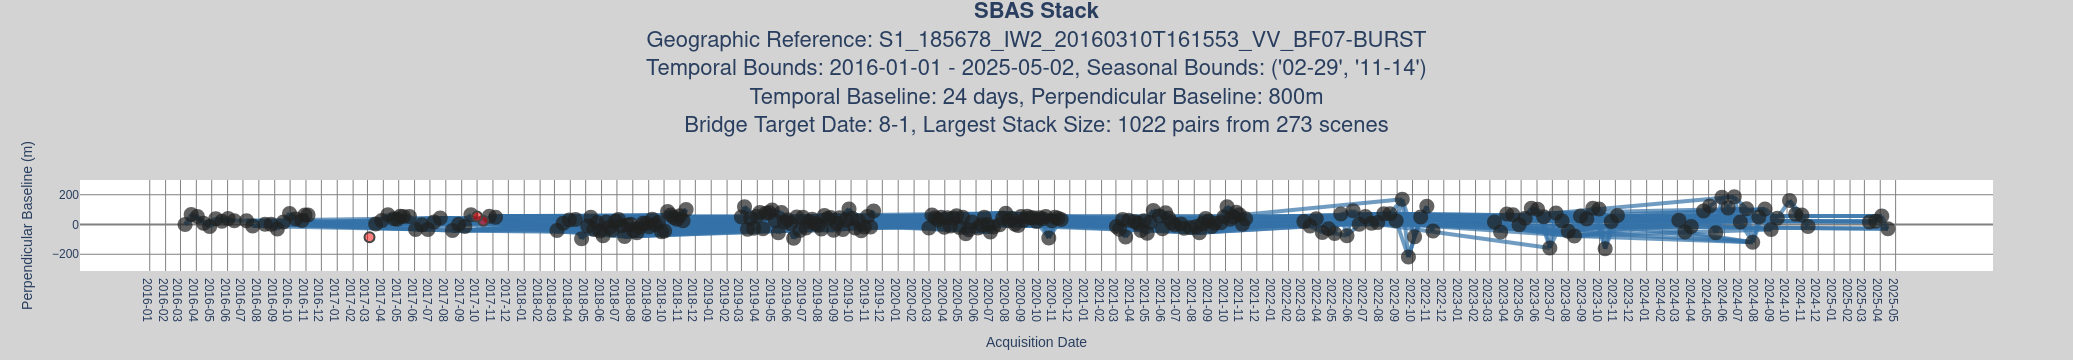

In [15]:
network.plot()

# 5. Prepare multiburst jobs for HyP3

**Get the burst pairs from the network**

In [12]:
refs, secs = network.get_multi_burst_pair_ids()

**Login into HyP3**

In [13]:
import hyp3_sdk as sdk

hyp3 = sdk.HyP3(prompt=True)

/home/mfangaritasr/anaconda3/envs/volcsarvatory3/lib/python3.12/site-packages/hyp3_sdk/hyp3.py:55: UserWarning:

Passing `prompt=True` is deprecated. Please use either `prompt="password"` or `prompt="token"`



NASA Earthdata Login username:  mfangaritasr
NASA Earthdata Login password:  ········


**Prepare the multiburst jobs**

In [15]:
project_name = 'Kilauea_124_test'
insar_jobs = pairs.prepare_multiburst_jobs(refs, secs, project_name, hyp3)

print(insar_jobs[0:2])

[{'job_parameters': {'reference': ['S1_264304_IW2_20150530T043022_VV_2FE7-BURST', 'S1_264304_IW3_20150530T043023_VV_2FE7-BURST', 'S1_264305_IW2_20150530T043025_VV_2FE7-BURST', 'S1_264305_IW3_20150530T043026_VV_2FE7-BURST', 'S1_264306_IW2_20150530T043028_VV_2FE7-BURST', 'S1_264306_IW3_20150530T043029_VV_2FE7-BURST', 'S1_264307_IW2_20150530T043031_VV_2FE7-BURST', 'S1_264307_IW3_20150530T043032_VV_2FE7-BURST', 'S1_264308_IW2_20150530T043033_VV_2FE7-BURST', 'S1_264308_IW3_20150530T043034_VV_2FE7-BURST', 'S1_264309_IW2_20150530T043036_VV_2FE7-BURST', 'S1_264309_IW3_20150530T043037_VV_2FE7-BURST', 'S1_264310_IW2_20150530T043039_VV_EE06-BURST', 'S1_264310_IW3_20150530T043040_VV_EE06-BURST', 'S1_264311_IW2_20150530T043042_VV_EE06-BURST', 'S1_264303_IW2_20150530T043020_VV_2FE7-BURST'], 'secondary': ['S1_264304_IW2_20150611T043023_VV_A984-BURST', 'S1_264304_IW3_20150611T043024_VV_A984-BURST', 'S1_264305_IW2_20150611T043026_VV_A984-BURST', 'S1_264305_IW3_20150611T043027_VV_A984-BURST', 'S1_264306

**Submit jobs to HyP3**

In [16]:
jobs = pairs.submit_jobs(insar_jobs, hyp3)

In [ ]:
for job in jobs:
    hyp3.watch(job)

  0%|          | 0/2 [timeout in 10800 s]